Or, being suspicious of market insiders.

---

Use the button below to show the code I've used to generate this article. Because there is a significant amount more code involved than most other posts I've written, it's hidden by default to allow people to concentrate on the important bits.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# The Market Just Knew

I recently saw two examples of stock charts that have kept me thinking for a while. And now that the semester is complete, I finally have enough time to really look at them and give them the treatment they deserve. The first is good old Apple:

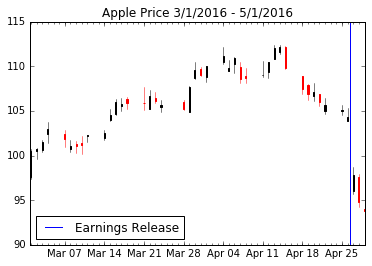

In [2]:
from secrets import QUANDL_KEY
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import quandl
from datetime import datetime
import pandas as pd
%matplotlib inline

def fetch_ticker(ticker, start, end):
    # Quandl is currently giving me issues with returning
    # the entire dataset and not slicing server-side.
    # So instead, we'll do it client-side!
    q_format = '%Y-%m-%d'
    ticker_data = quandl.get('YAHOO/' + ticker,
                             start_date=start.strftime(q_format),
                             end_date=end.strftime(q_format),
                             authtoken=QUANDL_KEY)
    return ticker_data

def ohlc_dataframe(data, ax=None):
    # Much of this code re-used from:
    # http://matplotlib.org/examples/pylab_examples/finance_demo.html
    if ax is None:
        f, ax = plt.subplots()
    
    vals = [(date2num(date), *(data.loc[date]))
            for date in data.index]
    candlestick_ohlc(ax, vals)
    
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter('%b %d')
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    return ax

AAPL = fetch_ticker('AAPL', datetime(2016, 3, 1), datetime(2016, 5, 1))
ax = ohlc_dataframe(AAPL)
plt.vlines(date2num(datetime(2016, 4, 26, 12)),
           ax.get_ylim()[0], ax.get_ylim()[1],
           color='b',
          label='Earnings Release')
plt.legend(loc=3)
plt.title("Apple Price 3/1/2016 - 5/1/2016");

The second chart is from Facebook:

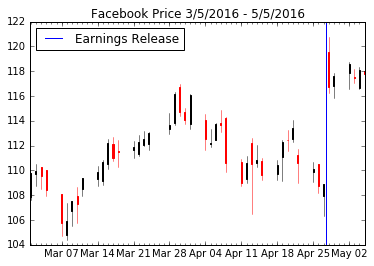

In [3]:
FB = fetch_ticker('FB', datetime(2016, 3, 1), datetime(2016, 5, 5))
ax = ohlc_dataframe(FB)
plt.vlines(date2num(datetime(2016, 4, 27, 12)),
           ax.get_ylim()[0], ax.get_ylim()[1],
           color='b', label='Earnings Release')
plt.title('Facebook Price 3/5/2016 - 5/5/2016')
plt.legend(loc=2);

These two charts demonstrate two very specific phonomena: how the market prepares for earnings releases. Let's look at those charts again, but with some extra information. As we're about the see, the market "knew" in advance that Apple was going to perform poorly. The market expected that Facebook was going to perform poorly, and instead shot the lights out. Let's see that trend in action:

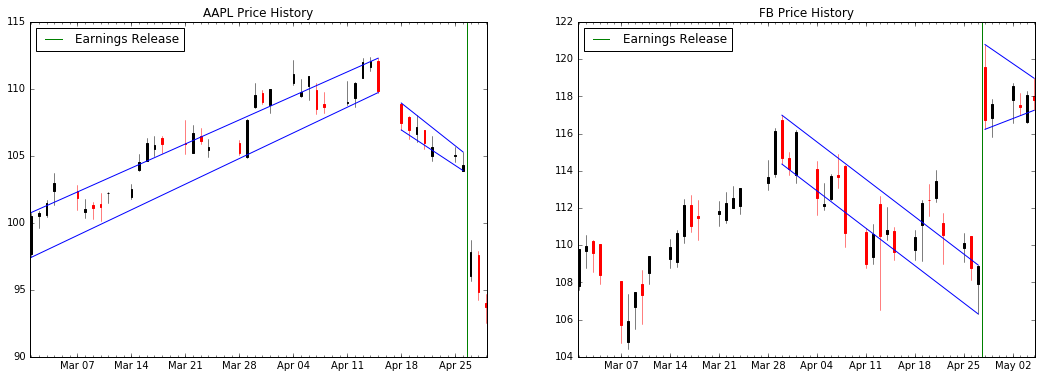

In [4]:
def plot_hilo(ax, start, end, data):
    ax.plot([date2num(start), date2num(end)],
            [data.loc[start]['High'], data.loc[end]['High']],
            color='b')
    ax.plot([date2num(start), date2num(end)],
            [data.loc[start]['Low'], data.loc[end]['Low']],
            color='b')

f, axarr = plt.subplots(1, 2)

ax_aapl = axarr[0]
ax_fb = axarr[1]

# Plot the AAPL trend up and down
ohlc_dataframe(AAPL, ax=ax_aapl)
plot_hilo(ax_aapl, datetime(2016, 3, 1), datetime(2016, 4, 15), AAPL)
plot_hilo(ax_aapl, datetime(2016, 4, 18), datetime(2016, 4, 26), AAPL)
ax_aapl.vlines(date2num(datetime(2016, 4, 26, 12)),
               ax_aapl.get_ylim()[0], ax_aapl.get_ylim()[1],
               color='g', label='Earnings Release')
ax_aapl.legend(loc=2)
ax_aapl.set_title('AAPL Price History')

# Plot the FB trend down and up
ohlc_dataframe(FB, ax=ax_fb)
plot_hilo(ax_fb, datetime(2016, 3, 30), datetime(2016, 4, 27), FB)
plot_hilo(ax_fb, datetime(2016, 4, 28), datetime(2016, 5, 5), FB)
ax_fb.vlines(date2num(datetime(2016, 4, 27, 12)),
             ax_fb.get_ylim()[0], ax_fb.get_ylim()[1],
             color='g', label='Earnings Release')
ax_fb.legend(loc=2)
ax_fb.set_title('FB Price History')

f.set_size_inches(18, 6)

As we can see above, the market broke a prevailing trend on Apple in order to go down, and ultimately predict the earnings release. For Facebook, the opposite happened. While the trend was down, the earnings were fantastic and the market corrected itself much higher.

# Formulating the Question

While these are two specific examples, there are plenty of other examples you could cite one way or another. Even if the preponderance of evidence shows that the market correctly predicts earnings releases, we need not accuse people of collusion; for a company like Apple with many suppliers we can generally forecast how Apple has done based on those same suppliers.

The question then, is this: **how well does the market predict the earnings releases?** It's an incredibly broad question that I want to disect in a couple of different ways:

1. Given a stock that has been trending down over the past N days before an earnings release, how likely does it continue downward after the release?
2. Given a stock trending up, how likely does it continue up?
3. Is there a difference in accuracy between large- and small-cap stocks?
4. How often, and for how long, do markets trend before an earnings release?

**I want to especially thank Alejandro Saltiel for helping me retrieve the data.** He's great. And now for all of the interesting bits.

# Event Studies

Before we go too much further, I want to introduce the actual event study. Each chart intends to capture a lot of information and present an easy-to-understand pattern:

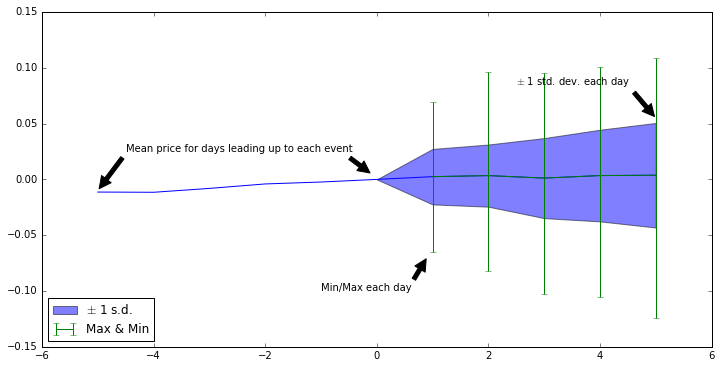

In [5]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

# If you remove rules, it removes them from *all* calendars
# To ensure we don't pop rules we don't want to, first make
# sure to fully copy the object
trade_calendar = USFederalHolidayCalendar()
trade_calendar.rules.pop(6) # Remove Columbus day
trade_calendar.rules.pop(7) # Remove Veteran's day
TradeDay = lambda days: CustomBusinessDay(days, calendar=trade_calendar)

def plot_study(array):
    # Given a 2-d array, we assume the event happens at index `lookback`,
    # and create all of our summary statistics from there.
    lookback = int((array.shape[1] - 1) / 2)
    norm_factor = np.repeat(array[:,lookback].reshape(-1, 1), array.shape[1], axis=1)
    centered_data = array / norm_factor - 1
    lookforward = centered_data.shape[1] - lookback
    means = centered_data.mean(axis=0)
    lookforward_data = centered_data[:,lookforward:]
    std_dev = np.hstack([0, lookforward_data.std(axis=0)])
    maxes = lookforward_data.max(axis=0)
    mins = lookforward_data.min(axis=0)
    
    f, axarr = plt.subplots(1, 2)
    range_begin = -lookback
    range_end = lookforward
    axarr[0].plot(range(range_begin, range_end), means)
    axarr[1].plot(range(range_begin, range_end), means)
    axarr[0].fill_between(range(0, range_end),
                     means[-lookforward:] + std_dev,
                     means[-lookforward:] - std_dev,
                    alpha=.5, label="$\pm$ 1 s.d.")
    axarr[1].fill_between(range(0, range_end),
                     means[-lookforward:] + std_dev,
                     means[-lookforward:] - std_dev,
                    alpha=.5, label="$\pm$ 1 s.d.")
    
    max_err = maxes - means[-lookforward+1:]
    min_err = means[-lookforward+1:] - mins
    axarr[0].errorbar(range(1, range_end),
                  means[-lookforward+1:],
                  yerr=[min_err, max_err], label='Max & Min')
    axarr[0].legend(loc=2)
    axarr[1].legend(loc=2)
    
    axarr[0].set_xlim((-lookback-1, lookback+1))
    axarr[1].set_xlim((-lookback-1, lookback+1))
    
def plot_study_small(array):
    # Given a 2-d array, we assume the event happens at index `lookback`,
    # and create all of our summary statistics from there.
    lookback = int((array.shape[1] - 1) / 2)
    norm_factor = np.repeat(array[:,lookback].reshape(-1, 1), array.shape[1], axis=1)
    centered_data = array / norm_factor - 1
    lookforward = centered_data.shape[1] - lookback
    means = centered_data.mean(axis=0)
    lookforward_data = centered_data[:,lookforward:]
    std_dev = np.hstack([0, lookforward_data.std(axis=0)])
    maxes = lookforward_data.max(axis=0)
    mins = lookforward_data.min(axis=0)
    
    range_begin = -lookback
    range_end = lookforward
    plt.plot(range(range_begin, range_end), means)
    plt.fill_between(range(0, range_end),
                     means[-lookforward:] + std_dev,
                     means[-lookforward:] - std_dev,
                    alpha=.5, label="$\pm$ 1 s.d.")
    
    max_err = maxes - means[-lookforward+1:]
    min_err = means[-lookforward+1:] - mins
    plt.errorbar(range(1, range_end),
                  means[-lookforward+1:],
                  yerr=[min_err, max_err], label='Max & Min')
    plt.legend(loc=2)
    plt.xlim((-lookback-1, lookback+1))
    
def fetch_event_data(ticker, events, horizon=5):
    # Use horizon+1 to account for including the day of the event,
    # and half-open interval - that is, for a horizon of 5,
    # we should be including 11 events. Additionally, using the
    # CustomBusinessDay means we automatically handle issues if
    # for example a company reports Friday afternoon - the date
    # calculator will turn this into a "Saturday" release, but
    # we effectively shift that to Monday with the logic below.
    td_back = TradeDay(horizon+1)
    td_forward = TradeDay(horizon+1)
    
    start_date = min(events) - td_back
    end_date = max(events) + td_forward
    total_data = fetch_ticker(ticker, start_date, end_date)
    event_data = [total_data.ix[event-td_back:event+td_forward]\
                      [0:horizon*2+1]\
                      ['Adjusted Close']
                  for event in events]
    return np.array(event_data)

# Generate a couple of random events

event_dates = [datetime(2016, 5, 27) - timedelta(days=1) - TradeDay(x*20) for x in range(1, 40)]
data = fetch_event_data('CELG', event_dates)
plot_study_small(data)
plt.legend(loc=3)
plt.gcf().set_size_inches(12, 6);


plt.annotate('Mean price for days leading up to each event',
             (-5, -.01), (-4.5, .025),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', (-.1, .005), (-.5, .02),
             arrowprops={'facecolor': 'black', 'shrink': .05})
plt.annotate('$\pm$ 1 std. dev. each day', (5, .055), (2.5, .085),
            arrowprops={'facecolor': 'black', 'shrink': .05})
plt.annotate('Min/Max each day', (.9, -.07), (-1, -.1),
            arrowprops={'facecolor': 'black', 'shrink': .05});

And as a quick textual explanation as well:

- The blue line represents the mean price for each day, represented as a percentage of the price on the '0-day'. For example, if we defined an 'event' as whenever the stock price dropped for three days, we would see a decreasing blue line to the left of the 0-day.

- The blue shaded area represents one standard deviation above and below the mean price for each day following an event. This is intended to give us an idea of what the stock price does in general following an event.

- The green bars are the minimum and maximum price for each day following an event. This instructs us as to how much it's possible for the stock to move.

# Event Type 1: Trending down over the past N days

The first type of event I want to study is how stocks perform when they've been trending down over the past couple of days prior to a release. However, we need to clarify what exactly is meant by "trending down." To do so, we'll use the following metric: **the midpoint between each day's opening and closing price goes down over a period of N days**.

It's probably helpful to have an example:

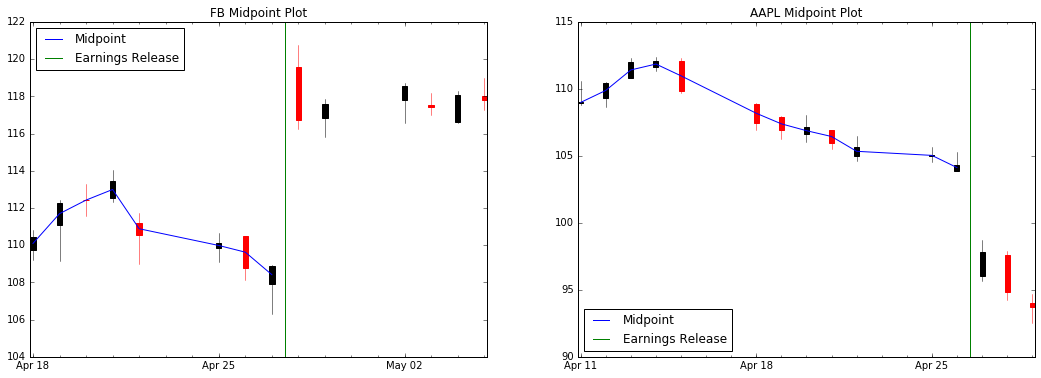

In [6]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(18, 6)

FB_plot = axarr[0]
ohlc_dataframe(FB[datetime(2016, 4, 18):], FB_plot)

FB_truncated = FB[datetime(2016, 4, 18):datetime(2016, 4, 27)]
midpoint = FB_truncated['Open']/2 + FB_truncated['Close']/2
FB_plot.plot(FB_truncated.index, midpoint, label='Midpoint')
FB_plot.vlines(date2num(datetime(2016, 4, 27, 12)),
               ax_fb.get_ylim()[0], ax_fb.get_ylim()[1],
               color='g', label='Earnings Release')
FB_plot.legend(loc=2)
FB_plot.set_title('FB Midpoint Plot')

AAPL_plot = axarr[1]
ohlc_dataframe(AAPL[datetime(2016, 4, 10):], AAPL_plot)
AAPL_truncated = AAPL[datetime(2016, 4, 10):datetime(2016, 4, 26)]
midpoint = AAPL_truncated['Open']/2 + AAPL_truncated['Close']/2
AAPL_plot.plot(AAPL_truncated.index, midpoint, label='Midpoint')
AAPL_plot.vlines(date2num(datetime(2016, 4, 26, 12)),
                 ax_aapl.get_ylim()[0], ax_aapl.get_ylim()[1],
                 color='g', label='Earnings Release')
AAPL_plot.legend(loc=3)
AAPL_plot.set_title('AAPL Midpoint Plot');

Given these charts, we can see that FB was trending down for the four days preceding the earnings release, and AAPL was trending down for a whopping 8 days (we don't count the peak day). This will define the methodology that we will use for the study.

So what are the results? For a given horizon, how well does the market actually perform?

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:21:38 Time: 0:21:38


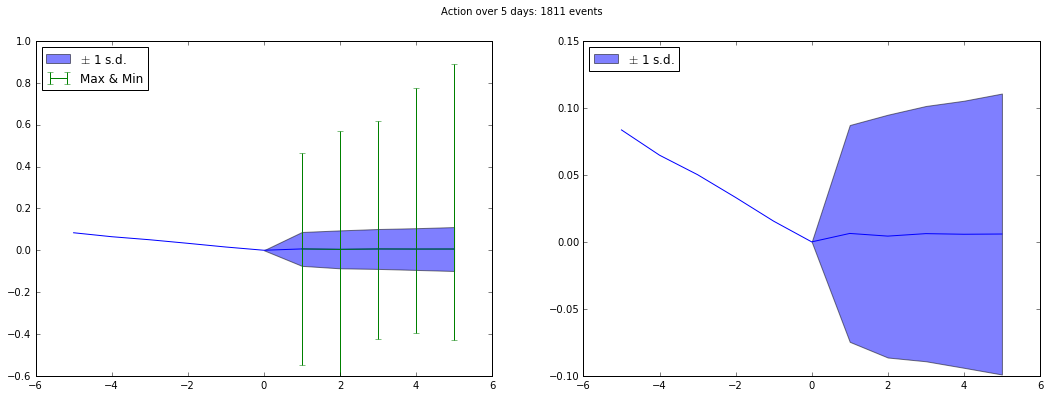

In [7]:
# Read in the events for each stock;
# The file was created using the first code block in the Appendix
import yaml
from dateutil.parser import parse
from progressbar import ProgressBar

data_str = open('earnings_dates.yaml', 'r').read()
# Need to remove invalid lines
filtered = filter(lambda x: '{' not in x, data_str.split('\n'))
earnings_data = yaml.load('\n'.join(filtered))

# Convert our earnings data into a list of (ticker, date) pairs
# to make it easy to work with.
# This is horribly inefficient, but should get us what we need
ticker_dates = []
for ticker, date_list in earnings_data.items():
    for iso_str in date_list:
        ticker_dates.append((ticker, parse(iso_str)))

def does_trend_down(ticker, event, horizon):
    # Figure out if the `event` has a downtrend for
    # the `horizon` days preceding it
    # As an interpretation note: it is assumed that
    # the closing price of day `event` is the reference
    # point, and we want `horizon` days before that.
    # The price_data.hdf was created in the second appendix code block
    try:
        ticker_data = pd.read_hdf('price_data.hdf', ticker)
        data = ticker_data[event-TradeDay(horizon):event]
        midpoints = data['Open']/2 + data['Close']/2

        # Shift dates one forward into the future and subtract
        # Effectively: do we trend down over all days?
        elems = midpoints - midpoints.shift(1)
        return len(elems)-1 == len(elems.dropna()[elems <= 0])
    except KeyError:
        # If the stock doesn't exist, it doesn't qualify as trending down
        # Mostly this is here to make sure the entire analysis doesn't 
        # blow up if there were issues in data retrieval
        return False

def study_trend(horizon, trend_function):
    five_day_events = np.zeros((1, horizon*2 + 1))
    invalid_events = []
    for ticker, event in ProgressBar()(ticker_dates):
        if trend_function(ticker, event, horizon):
            ticker_data = pd.read_hdf('price_data.hdf', ticker)
            event_data = ticker_data[event-TradeDay(horizon):event+TradeDay(horizon)]['Close']

            try:
                five_day_events = np.vstack([five_day_events, event_data])
            except ValueError:
                # Sometimes we don't get exactly the right number of values due to calendar
                # issues. I've fixed most everything I can, and the few issues that are left
                # I assume don't systemically bias the results (i.e. data could be missing
                # because it doesn't exist, etc.). After running through, ~1% of events get
                # discarded this way
                invalid_events.append((ticker, event))
            

    # Remove our initial zero row
    five_day_events = five_day_events[1:,:]
    plot_study(five_day_events)
    plt.gcf().suptitle('Action over {} days: {} events'
                       .format(horizon,five_day_events.shape[0]))
    plt.gcf().set_size_inches(18, 6)
    
# Start with a 5 day study
study_trend(5, does_trend_down)

When a stock has been trending down for 5 days, once the earnings are announced it really doesn't move on average. However, the variability is *incredible*. This implies two important things:

1. The market is just as often wrong about an earnings announcement before it happens as it is correct
2. The incredible width of the min/max bars and standard deviation area tell us that the market reacts *violently* after the earnings are released.

Let's repeat the same study, but over a time horizon of 8 days and 3 days. Presumably if a stock has been going down for 8 days at a time before the earnings, the market should be more accurate.

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:20:29 Time: 0:20:29


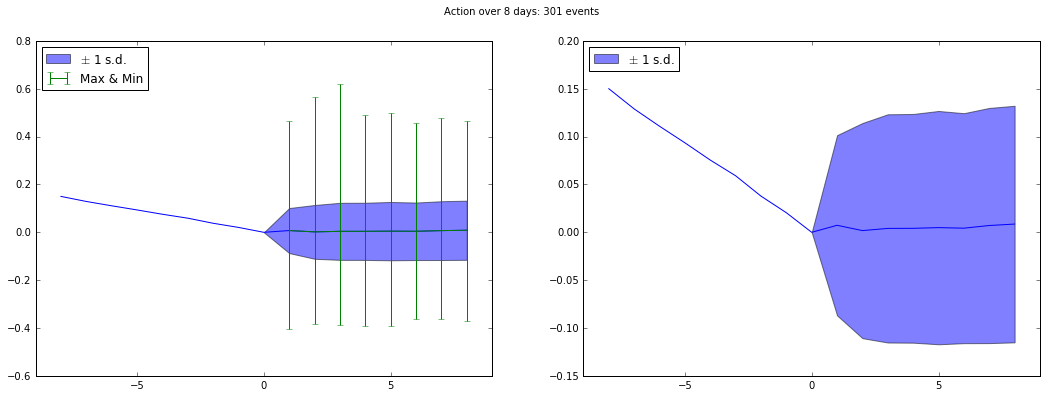

In [8]:
# 8 day study next
study_trend(8, does_trend_down)

However, looking only at stocks that trended down for 8 days prior to a release, the same pattern emerges: on average, the stock doesn't move, but the market reaction is often incredibly violent.

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:26:26 Time: 0:26:26


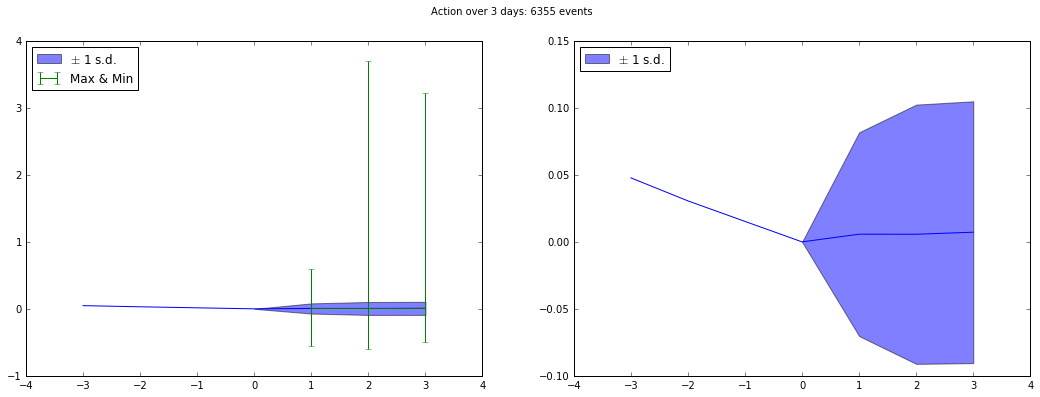

In [9]:
# 3 day study after that
study_trend(3, does_trend_down)

Finally, when we look at a 3-day horizon, we start getting some incredible outliers. Stocks have a potential to move over ~300% up, and the standard deviation width is again, incredible. The results for a 3-day horizon follow the same pattern we've seen in the 5- and 8-day horizons.

# Event Type 2: Trending up for N days

We're now going to repeat the analysis, but do it for uptrends instead. That is, instead of looking at stocks that have been trending down over the past number of days, we focus only on stocks that have been trending up.

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:22:51 Time: 0:22:51


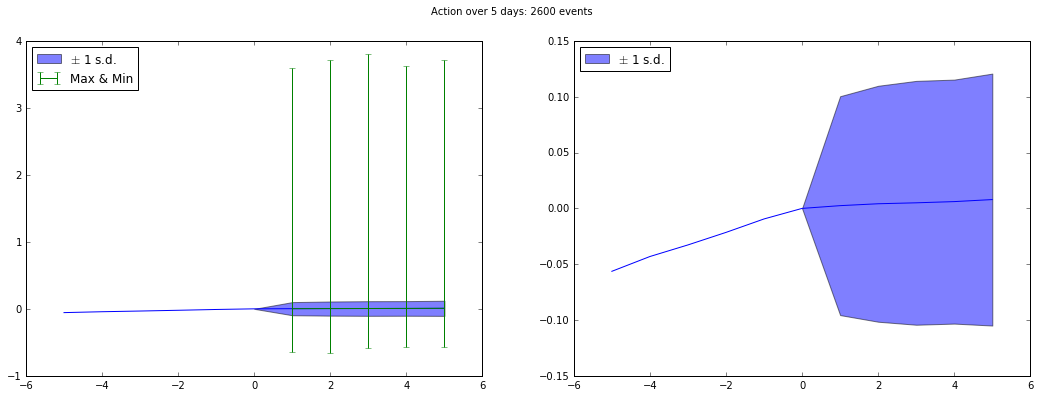

In [10]:
def does_trend_up(ticker, event, horizon):
    # Figure out if the `event` has an uptrend for
    # the `horizon` days preceding it
    # As an interpretation note: it is assumed that
    # the closing price of day `event` is the reference
    # point, and we want `horizon` days before that.
    # The price_data.hdf was created in the second appendix code block
    try:
        ticker_data = pd.read_hdf('price_data.hdf', ticker)
        data = ticker_data[event-TradeDay(horizon):event]
        midpoints = data['Open']/2 + data['Close']/2

        # Shift dates one forward into the future and subtract
        # Effectively: do we trend down over all days?
        elems = midpoints - midpoints.shift(1)
        return len(elems)-1 == len(elems.dropna()[elems >= 0])
    except KeyError:
        # If the stock doesn't exist, it doesn't qualify as trending down
        # Mostly this is here to make sure the entire analysis doesn't 
        # blow up if there were issues in data retrieval
        return False

study_trend(5, does_trend_up)

The patterns here are very similar. With the exception of noting that stocks can go to nearly 400% after an earnings announcement (most likely this included a takeover announcement, etc.), we still see large min/max bars and wide standard deviation of returns.

We'll repeat the pattern for stocks going up for both 8 and 3 days straight, but at this point, the results should be very predictable:

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:20:51 Time: 0:20:51


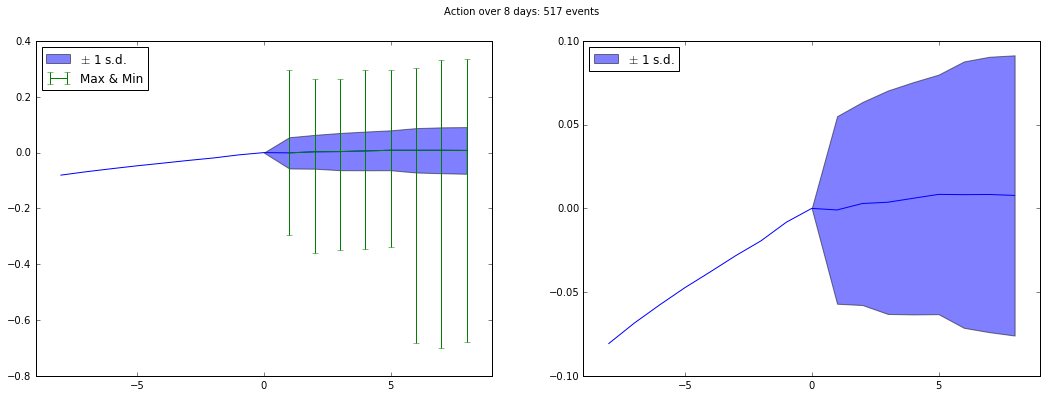

In [11]:
study_trend(8, does_trend_up)

100% (47578 of 47578) |###########################################################| Elapsed Time: 0:26:56 Time: 0:26:56


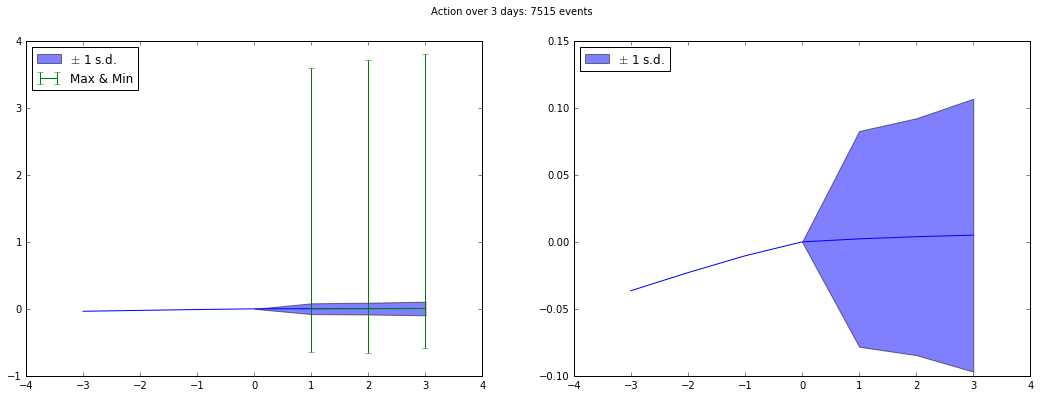

In [12]:
study_trend(3, does_trend_up)

# Conclusion and Summary

I guess the most important thing to summarize with is this: **looking at the entire market, stock performance prior to an earnings release has no bearing on the stock's performance.** Honestly: given the huge variability of returns after an earnings release, even when the stock has been trending for a long time, you're best off divesting before an earnings release and letting the market sort itself out.

*However*, there is a big caveat. These results are taken when we look at the entire market. So while we can say that the market as a whole knows nothing and just reacts violently, I want to take a closer look into this data. Does the market typically perform poorly on large-cap/high liquidity stocks? Do smaller companies have investors that know them better and can thus predict performance better? Are specific market sectors better at prediction? Presumably technology stocks are more volatile than the industrials.

So there are some more interesting questions I still want to ask with this data. Knowing that the hard work of data processing is largely already done, it should be fairly simple to continue this analysis and get much more refined with it. Until next time.

# Appendix

Export event data for Russell 3000 companies:

```python
import pandas as pd
from html.parser import HTMLParser
from datetime import datetime, timedelta
import requests
import re
from dateutil import parser
import progressbar
from concurrent import futures
import yaml

class EarningsParser(HTMLParser):
    store_dates = False
    earnings_offset = None
    dates = []
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dates = []
    
    def handle_starttag(self, tag, attrs):
        if tag == 'table':
            self.store_dates = True
            
    def handle_data(self, data):
        if self.store_dates:
            match = re.match(r'\d+/\d+/\d+', data)
            if match:
                self.dates.append(match.group(0))
        
        # If a company reports before the bell, record the earnings date
        # being at midnight the day before. Ex: WMT reports 5/19/2016,
        # but we want the reference point to be the closing price on 5/18/2016
        if 'After Close' in data:
            self.earnings_offset = timedelta(days=0)
        elif 'Before Open' in data:
            self.earnings_offset = timedelta(days=-1)
                
    def handle_endtag(self, tag):
        if tag == 'table':
            self.store_dates = False
            
def earnings_releases(ticker):
    #print("Looking up ticker {}".format(ticker))
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:46.0) '\
        'Gecko/20100101 Firefox/46.0'
    headers = {'user-agent': user_agent}
    base_url = 'http://www.streetinsider.com/ec_earnings.php?q={}'\
        .format(ticker)
    e = EarningsParser()
    s = requests.Session()
    a = requests.adapters.HTTPAdapter(max_retries=0)
    s.mount('http://', a)
    e.feed(str(s.get(base_url, headers=headers).content))
    
    if e.earnings_offset is not None:
        dates = map(lambda x: parser.parse(x) + e.earnings_offset, e.dates)
        past = filter(lambda x: x < datetime.now(), dates)
        return list(map(lambda d: d.isoformat(), past))

# Use a Russell-3000 ETF tracker (ticker IWV) to get a list of holdings
r3000 = pd.read_csv('https://www.ishares.com/us/products/239714/'
                    'ishares-russell-3000-etf/1449138789749.ajax?'
                    'fileType=csv&fileName=IWV_holdings&dataType=fund',
                    header=10)
r3000_equities = r3000[(r3000['Exchange'] == 'NASDAQ') |
                       (r3000['Exchange'] == 'New York Stock Exchange Inc.')]

dates_file = open('earnings_dates.yaml', 'w')

with futures.ThreadPoolExecutor(max_workers=8) as pool:
    fs = {pool.submit(earnings_releases, r3000_equities.ix[t]['Ticker']): t
          for t in r3000_equities.index}
    pbar = progressbar.ProgressBar(term_width=80,
                                   max_value=r3000_equities.index.max())
    
    for future in futures.as_completed(fs):
        i = fs[future]
        pbar.update(i)
        dates_file.write(yaml.dump({r3000_equities.ix[i]['Ticker']:
            future.result()}))
```

Downloading stock price data needed for the event studies:

```python
from secrets import QUANDL_KEY
import pandas as pd
import yaml
from dateutil.parser import parse
from datetime import timedelta
import quandl
from progressbar import ProgressBar

def fetch_ticker(ticker, start, end):
    # Quandl is currently giving me issues with returning
    # the entire dataset and not slicing server-side.
    # So instead, we'll do it client-side!
    q_format = '%Y-%m-%d'
    ticker_data = quandl.get('YAHOO/' + ticker,
                             start_date=start.strftime(q_format),
                             end_date=end.strftime(q_format),
                             authtoken=QUANDL_KEY)
    return ticker_data
    
data_str = open('earnings_dates.yaml', 'r').read()
# Need to remove invalid lines
filtered = filter(lambda x: '{' not in x, data_str.split('\n'))
earnings_data = yaml.load('\n'.join(filtered))

# Get the first 1500 keys - split up into two statements
# because of Quandl rate limits
tickers = list(earnings_data.keys())

price_dict = {}
invalid_tickers = []
for ticker in ProgressBar()(tickers[0:1500]):
    try:
        # Replace '.' with '-' in name for some tickers
        fixed = ticker.replace('.', '-')
        event_strs = earnings_data[ticker]
        events = [parse(event) for event in event_strs]
        td = timedelta(days=20)
        price_dict[ticker] = fetch_ticker(fixed,
            min(events)-td, max(events)+td)
    except quandl.NotFoundError:
        invalid_tickers.append(ticker)
        
# Execute this after 10 minutes have passed
for ticker in ProgressBar()(tickers[1500:]):
    try:
        # Replace '.' with '-' in name for some tickers
        fixed = ticker.replace('.', '-')
        event_strs = earnings_data[ticker]
        events = [parse(event) for event in event_strs]
        td = timedelta(days=20)
        price_dict[ticker] = fetch_ticker(fixed,
            min(events)-td, max(events)+td)
    except quandl.NotFoundError:
        invalid_tickers.append(ticker)
 
prices_store = pd.HDFStore('price_data.hdf')
for ticker, prices in price_dict.items():
    prices_store[ticker] = prices
```